# Kapitel 04

> ### <span style="color:red">ACHTUNG:</span> Bitte zum Starten im Menü `Cell • Run All` ausführen.

## Deaktivieren der Warnungen

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Perceptron Lernalgorithmus

#### Listing 4.1

In [ ]:
# Plot
import matplotlib.pyplot as plt
# Zufallszahlen Generator
from random import choice
# Für die mathematischen Operationen
from numpy import array, dot, zeros, random
# Ganz wichtig, sonst wird der Plot nicht angezeigt
%matplotlib inline

# Die heaviside Stufenfunktion als Lambda Funktion
heaviside = lambda x: 0 if x < 0 else 1

# Training
def fit(iterations, training_data_set,w):
    """ Lernen im Perceptron 
    iterations: Ein Vorwärts- und Rückwärtslauf aller Trainingsbeispiele
    trainings_data_set: Die Trainingsbeispiele
    w: Die Gewichte zum Starten
    """
    errors = []
    weights = []
    for i in range(iterations):
        # zufällige Auswahl eines Trainingsbeispiels random.choice
        training_data = choice(training_data_set)
        x = training_data[0] 
        y = training_data[1] 
        # Den errechneten Output ermitteln: Gewichtete Summe mit 
        # nachgelagerter Stufenfunktion
        y_hat = heaviside(dot(w, x))
        # Fehler berechnen als Differenz zwischen gewünschtem und 
        # aktuellem Output    
        error = y - y_hat
        # Fehler sammeln für die Ausgabe    
        errors.append(error)
        # Gewichte sammeln für spätere Ausgabe
        weights.append(w)
        # Gewichtsanpassung = Das Lernen… x_i ist entweder 0 oder 1
        w += error * x
        # Rückgabe der Fehler und Gewichte
    return errors, weights

def main():
    """ Hauptprogramm
    Hier werden die einzelnen Bausteine zusammengesetzt
    """
    # Trainingsdaten
    # Pro Zeile: die binären Inputdaten und die gewünschte binäre Ausgabe 
    # in einer Liste von Tupeln. 
    # An der Indexposition 0 des Inputvektors ist das Bias Neuron
    training_data_set = [
        (array([1,0,0]), 0),
        (array([1,0,1]), 1),
        (array([1,1,0]), 1),
        (array([1,1,1]), 1),
    ]

    # Anfangsinitialisierung des Zufallgenerators wegen 
    # Reproduzierbarkeit der Ergebnisse
    random.seed( 12 ) # irgendein Wert

    # Array von Länge 3 mit 0 initialisieren
    w = zeros(3)
    # Die Anzahl der Durchläufe. Erfahrungswert durch Probieren
    iterations = 30
    
    # Trainieren mit fit()
    # Wir sammeln die Fehler/Gewichte in jedem Schritt für die grafische Ausgabe
    errors, weights = fit(iterations, training_data_set,w) 
    # Den letzten Gewichtsvektor ausgeben
    w = weights[iterations-1]
    print("Gewichtsvektor am Ende des Trainings:")
    print(w)

    # Auswertung nach dem Trainieren
    print("Auswertung am Ende des Trainings:")
    for x, y in training_data_set:
        y_hat = heaviside(dot(x, w))
        print("{}: {} -> {}".format(x, y, y_hat)) 
   
    # Grafik für Fehler pro Lernbeispiel :-)  
    # Figure Nummern Start
    fignr = 1
    # Druckgröße in inch
    plt.figure(fignr,figsize=(10,10))
    # Ausgabe Fehler als Plot
    plt.plot(errors)
    # Raster
    plt.style.use('seaborn-whitegrid')  
    # Labels
    plt.xlabel('Iteration')
    # Label der y-Achse mit Hilfe von LaTex
    plt.ylabel(r"$(y - \hat y)$")
    # Plot anzeigen
    plt.show()    

# Hauptprogramm 
main()


## Perceptron: scikit-learn Estimator und Predictor

#### Listing 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9

In [ ]:
# Numpy hilft uns mit den arrays
import numpy as np
# Grafische Darstellung
import matplotlib.pyplot as plt
# Das sind unsere Basisklassen
from sklearn.base import BaseEstimator, ClassifierMixin
# Prüfroutinen für die Konsistenz der Daten, etc.
from sklearn.utils.validation import check_X_y, check_is_fitted, check_random_state
# Puffern der unterschiedlichen Zielwerte
from sklearn.utils.multiclass import unique_labels
# Ganz wichtig, sonst wird der Plot nicht angezeigt
%matplotlib inline

# Unser Estimator, passend bezeichnet und die Basisklassen
class PerceptronEstimator(BaseEstimator, ClassifierMixin):
    # Initialisierung
    def __init__(self, n_iterations=20, random_state=None):
        """ Initialisierung der Objekte        
        n_iterations: Anzahl der Iterationen für das Lernen
        random_state_seed: Um Wiederholbarkeit zu garantieren sollte ein 
                      numpy.random.RandomState Objekt konstruiert werden, 
                      das mit random_state_seed Seed initialisiert wurde       
        """
        # Die Anzahl der Iterationen        
        self.n_iterations = n_iterations
        # Die Seed für den Zufallsgenerator
        self.random_state = random_state
        # Die Fehler im Lernprozeß für den Plot gepuffert
        self.errors = []

    # Eine Stufenfunktion, benannt nach dem Mathematiker und Physiker 
    # Oliver Heaviside
    def heaviside(self, x):
        """ Eine Stufenfunktion       
        x: Der Wert für den die Stufenfunktion ausgewertet wird       
        """ 
        if x < 0:
            result = 0
        else:
            result = 1
        return result
    
    # Lernen
    def fit(self, X=None, y=None ):
        """ Trainieren       
        X: Array-ähnliche Struktur mit [N,D], wobei 
           N = Zeilen = Anzahl der Lernbeispiele und 
           D = Spalten = Anzahl der Features 
        y: Array mit [N], mit N so wie oben        
        """ 
        # Erzeugung des Zufallsgenerators (RNG)
        random_state = check_random_state(self.random_state)
        # Gewichtinitialisierung
        # np.size(.,1) = Anzahl der Spalten
        self.w = random_state.random_sample(np.size(X,1))       
        # Prüfe, ob X und y die korrekte shape haben: X.shape[0] = y.shape[0]
        X, y = check_X_y(X, y)
        # Die eindeutigen Zielwerte speichern
        self.classes_ = unique_labels(y)
        # Lerndaten für spätere Prüfung in Methode predict speichern
        self.X_ = X
        self.y_ = y      
        # Lernen 
        for i in range(self.n_iterations):
            # zufälliges durchwürfeln, für batch size = 1     
            # np.size(.,0) = Anzahl der Zeilen
            rand_index = random_state.randint(0,np.size(X,0))
            # Ein zufälliger Inputvektor
            x_ = X[rand_index]
            # Ein dazu passender Output
            y_ = y[rand_index]
            # Den errechneten Output ermitteln: 
            # Gewichtete Summe mit nachgelagerter Stufenfunktion
            y_hat = self.heaviside(np.dot(self.w, x_))
            # Fehler berechnen als Differenz zwischen gewünschtem und 
            # aktuellem Output    
            error = y_ - y_hat
            # Fehler sammeln für die Ausgabe    
            self.errors.append(error)
            # Gewichtsanpassung = Das Lernen   
            self.w += error * x_
            # Rückgabe des Estimators für verknüpfte Aufrufe
        return self
    
    # Auswerten
    def predict(self, x):
        """ Auswerten eines Vektors        
        x: Ein Test Inputvektor         
        """   
        # Prüfen, ob fit berereits aufgerufen wurde
        # Die Daten wurden in der Methode fit gesetzt
        check_is_fitted(self, ['X_', 'y_'])
        # Auswerten, Forward Path
        y_hat = self.heaviside(np.dot(self.w,x))

        return y_hat
    
    # Plot
    def plot(self):
        """ Ausgabe des Fehlers       
        Die im Fehlerarray gespeicherten Fehler als Grafik ausgeben       
        """         
        # Figure-Nummern Start
        fignr = 1
        # Druckgröße in inch
        plt.figure(fignr,figsize=(10,10))
        # Ausgabe Fehler als Plot
        plt.plot(self.errors)
        # Raster
        plt.style.use('seaborn-whitegrid')  
        # Labels
        plt.xlabel('Iteration')
        plt.ylabel(r"$(y - \hat y)$")

def main():
    # Trainingsdaten
    X = np.array([[1,0,0], [1,0,1], [1,1,0],[1,1,1]])
    y = np.array([0,1,1,1])
    # Lernen
    Perceptron = PerceptronEstimator(30,10)
    Perceptron.fit(X,y) 
    # Auswertung
    for index, x in enumerate(X):
        p = Perceptron.predict(x)
        print("{}: {} -> {}".format(x, y[index],p))
    # Graph ausgeben    
    Perceptron.plot()

# Hauptprogramm 
main()    

## Scikit-Learn Perceptron und Blobs

#### Listing 4.10

In [ ]:
# Mathematik
import numpy as np
# Grafische Ausgabe für Daten-Blobs und Klassifikation
import matplotlib.pyplot as plt
# Datenerzeugung
from sklearn import datasets
# Ladies and Gentlemen – Das Perceptron
from sklearn.linear_model import Perceptron

# Daten erstellen für das Lernen mit Hilfe von scikit-learn
# Wir erzeugen zwei Punkthaufen, mit zwei Kategorien, die linear trennbar sind
# n_samples = Anzahl an Datenpunkten pro Kategorie
# n_features = Anzahl der Kategorien
# centers = Anzahl der Punkthaufen
# random_state = Seed für Zufallsgenerator
X, y = datasets.make_blobs(n_samples=100, n_features=2, centers=2,\
                           random_state=3)
# Klassifikationen
# Aufbau eines Raster, um auszuwerten und zu zeichnen
s = 0.02  # Schrittweite im Raster
# Ermittlung der 1-D Arrays, die die Koordinaten im Raster repräsentieren
# Slices werden im Anhang A erläutert
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # erste Koordinate
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # zweite Koordinate
# np.arange liefert ein ndarray mit gleichmäßig verteilten Werten
# np.meshgrid liefert Koordinatenmatrizen von Koordinaten Vektoren
xx, yy = np.meshgrid(np.arange(x_min, x_max, s),
                     np.arange(y_min, y_max, s))
# Das Perceptron instanziieren
# max_iter = Maximale Anzahl an Iterationen
# tol = Stoppkriterium
Perceptron = Perceptron(random_state=42,max_iter=1000)
# Lernen bitte
Perceptron.fit(X,y)
# Auswertung für alle Rasterpunkte, dazu wird ein Array Rasterpunkten erzeugt
# ravel() erzeugt ein 1-D array
# np.c_ erzeugt ein Punktpärchen Arrays für jeden Rasterpunkt, 
#       die als Input für das Perceptron dienen
Prediction = Perceptron.predict(np.c_[xx.ravel(), yy.ravel()])    
# Daten anzeigen in einem Plot
# Zuerst plotten der Punkthaufen
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'b^') # blaue Dreiecke
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'ys') # gelbe Quadrate
# Umwandlung von 1-D Array in die Rasterdimensionen 
#                               [x_min, x_max] mal [y_min, y_max]
Prediction = Prediction.reshape(xx.shape)
# Plotten der Vorhersagen 
plt.contourf(xx, yy, Prediction, cmap=plt.cm.Paired)
# und alles anzeigen
plt.show()

## Adaline

#### Listing 4.11, Listing 4.12, Listing 4.13, Listing 4.14

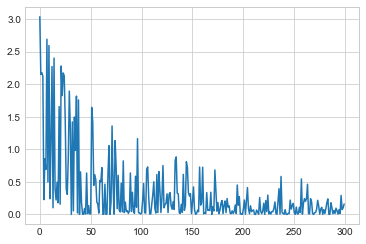

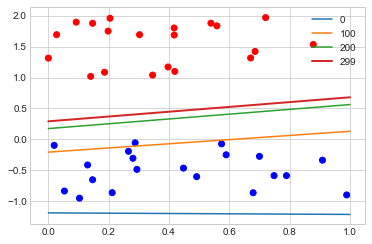

In [3]:
# Numpy hilft uns mit den arrays
import numpy as np
# Grafische Darstellung
import matplotlib.pyplot as plt
# Das sind unsere Basisklassen
from sklearn.base import BaseEstimator, ClassifierMixin
# Prüfroutinen 
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
# Speichern 
from sklearn.utils.multiclass import unique_labels
# Ganz wichtig, sonst wird der Plot nicht angezeigt
%matplotlib inline

# Unser Estimator, passend bezeichnet und die Basisklassen
class AdalineEstimator(BaseEstimator, ClassifierMixin):
    # Initialisierung    
    def __init__(self, eta=.001, n_iterations=500, random_state=None):
        """ Initialisierung der Objekte
        
        eta:          Lernrate
        n_iterations: Anzahl der Iterationen für das Lernen
        random_state: Um Wiederholbarkeit zu garantieren sollte ein numpy.random.RandomState Objekt 
                      konstruiert werden, das mit random_state Seed initialisiert wurde 
                      
        """
        # Die Anzahl der Iterationen   
        self.n_iterations = n_iterations
        # Die Seed für den Zufallsgenerator
        self.random_state = random_state        
        # Die Fehler im Lernprozeß für den Plot gepuffert
        self.errors = []
        # Die Lernrate    
        self.eta = eta
        # Gewichte für die Berechnung im KNN
        self.w = []
        # Alle Gewichte für Plot, zum Zeichnen der Trenngeraden     
        self.wAll = []
        
    # Der gewichtete Input       
    def net_i(self, x):
        """ Den gewichteten Input w*x berechnen      
        x: Ein Vektor          
        """
        return np.dot(x, self.w)
    
    # Aktivierungsfunktion
    def activation(self, x):
        """ Lineare Aktivierungsfunktion      
        """
        return self.net_i(x)
    
    # Outputfunktion, wobei der Output 1 und -1 sein kann 
    # im Gegensatz zum Perceptron, wo 1 und 0 ausgegeben werden
    def output(self, x):
        """ Outputfunktion      
        """
        if self.activation(x) >= 0.0:
            return 1
        else:
            return -1
        
    # Lernen
    def fit(self, X=None, y=None):
        """ Trainieren        
        X: Array-ähnliche Struktur mit [N,D], wobei 
           N = Zeilen = Anzahl der Lernbeispiele und 
           D = Spalten = Anzahl der Features 
        y: Array mit [N], mit N so wie oben       
        """ 
        # Erzeugung des Zufallsgenerators (RNG)
        random_state = check_random_state(self.random_state)        
        # Gewichtinitialisierung
        # np.size(.,1) = Anzahl der Spalten
        self.w = random_state.random_sample(np.size(X,1)) 
        # Prüfe, ob X und y die korrekte Shape haben: X.shape[0] = y.shape[0]
        X, y = check_X_y(X, y)
        # Lerndaten für spätere Verwendung ablegen
        self.X_ = X
        self.y_ = y      
        # Lernen mit Gradientenabstieg 
        for i in range(self.n_iterations):
            # zufälliges durchwürfeln, für batch size = 1     
            # np.size(.,0) = Anzahl der Zeilen
            rand_index = random_state.randint(0,np.size(X,0)) 
            # Ein zufälliger Inputvektor
            x_ = X[rand_index]
            # Ein dazu passender Output (+1,-1)
            y_ = y[rand_index]
            # net input s berechnen
            s = np.dot(x_, self.w)
            # Fehler berechnen als Quadrat der Differenz zwischen 
            # gewünschem Output und net input
            error = (y_ - s)**2
            self.errors.append(error)
            # Adaline Lernen, so wie beschrieben
            self.w += self.eta * x_ * (y_ - s)
            # .copy() kopiert die Liste
            self.wAll.append(self.w.copy())
            
    # Auswerten                
    def predict(self,x):
        """ Auswerten eines Vektors    
        x: Ein Test Inputvektor        
        """   
        # Prüfen, ob fit aufgerufen wurde
        # Die Daten wurden in der Methode fit gesetzt
        check_is_fitted(self, ['X_', 'y_'])
        # Auswerten, Forward Path
        y_hat = self.output(x)  
        
        return y_hat
    
    # Plot        
    def plot(self):
        """ Ausgabe des Fehlers und der Lernkurve       
        Die im Fehlerarray gespeicherten Fehler als Grafik ausgeben
        Die Trenngeraden aus den gespeicherten Gewichten ausgeben        
        """                 
        x1 = []
        x2 = []
        colors = []
        
        for i in range(self.X_.shape[0]):
            x1.append(self.X_[i][1])
            x2.append(self.X_[i][2])
            y = self.y_[i]
            if y == 1:
                colors.append('r') # rot
            else:
                colors.append('b') # blau
        # Raster
        plt.style.use('seaborn-whitegrid')
        # Errors
        plt.plot(self.errors)        
        # Learning Curve
        plt.figure(1)    
        plt.show()
        # Scatter
        plt.figure(2)
        plt.scatter(x1, x2,c=colors)  
        # Result Line
        x1Line = np.linspace(0.0, 1.0, 2)
        x2Line = lambda x1, w0, w1, w2: (-x1*w1 - w0) / w2;
        alpha = 0.0
        for idx, weight in enumerate(self.wAll):
            # alpha = Transparenz, je näher zum Ziel desto dunkler
            if(idx % 100 == 0):
                alpha = 1.0 #( idx / len(self.wAll) )
                plt.plot(x1Line, x2Line(x1Line,weight[0],weight[1],weight[2]), alpha=alpha , linestyle='solid', label=str(idx), linewidth=1.5)      
        # Ergebnisgerade 
        plt.plot(x1Line, x2Line(x1Line,weight[0],weight[1],weight[2]), alpha=alpha , linestyle='solid', label=str(idx), linewidth=2.0)  
        plt.legend(loc='best', shadow=True)
        
def main():
    # Erzeugung des Zufallsgenerators (RNG)
    random_state = check_random_state(1)        
    # Initialisierung Datensätze
    I = []
    o = []
    # Datensätze für zwei Kategorien aufbauen 
    # Diesesmal ohne scikit-learn
    for x in random_state.random_sample(20):
        y = random_state.random_sample()
        I.append([1, x, y+1.0]) # Falls +0.0, dann überlappende Kategorien
        o.append(1)

    for x in random_state.random_sample(20):
        y = random_state.random_sample()
        I.append([1, x, y-1.0]) # Falls +0.0, dann überlappende Kategorien
        o.append(-1)

    # Trainingsdaten
    X = np.array(I)
    y = np.array(o)
    # Walte deines Amtes Estimator
    Adaline = AdalineEstimator(eta=0.01,n_iterations=300, random_state=10)
    # Lernen
    Adaline.fit(X,y)
    # Graphen ausgeben
    Adaline.plot()

# Hauptprogramm 
main()  